# Import

In [1]:
from pprint import pprint

from IPython.display import display
from hamilton import driver
import pandas as pd

import __init__ as nixtla_statsforecast

/home/tjean/projects/dagworks/hamilton/venv/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Build Driver

Note: Hamilton collects completely anonymous data about usage. This will help us improve Hamilton over time. See https://github.com/dagworks-inc/hamilton#usage-analytics--data-privacy for details.


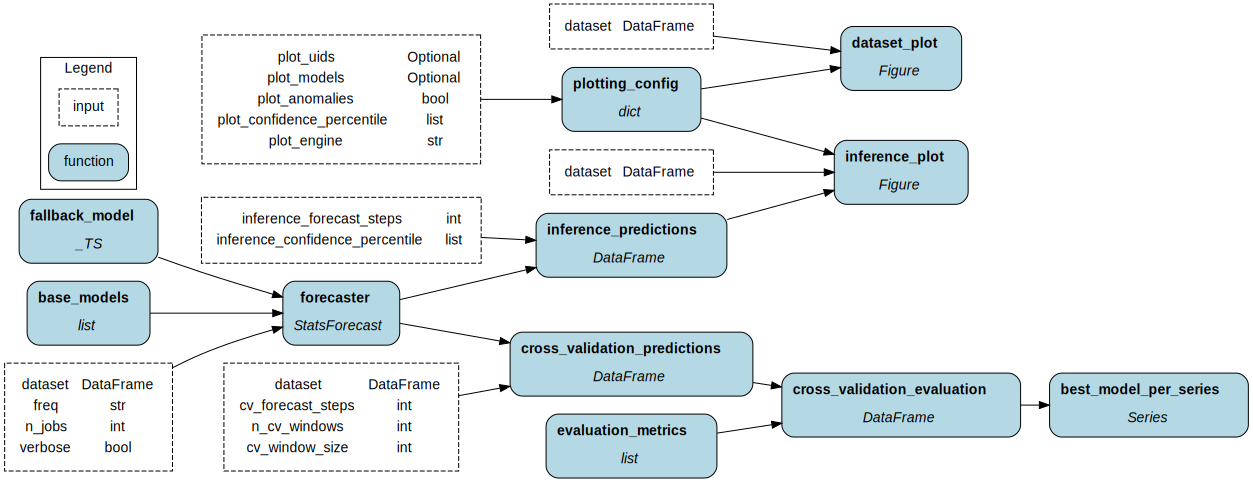

In [2]:
dr = (
    driver.Builder()
    .with_modules(nixtla_statsforecast)
    .build()
)

# create the DAG image
display(dr.display_all_functions(None))

# Load dataset

In [3]:

def download_m4_dataset() -> pd.DataFrame:
    """Download Nixtla's version of the M4 hourly dataset. ref: https://paperswithcode.com/dataset/m4"""
    return pd.read_parquet("https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet")


def filter_dataset(raw_dataset: pd.DataFrame, n_ids: int = 4, n_days: int = 7) -> pd.DataFrame:
    """Filter the dataset to `n_ids` series for a period of `n_days`"""
    selection = raw_dataset.unique_id.unique()[:n_ids]
    df = raw_dataset.loc[raw_dataset.unique_id.isin(selection)]
    df = df.groupby("unique_id").tail(n_days * 24)  # the dataset contains 24 points per day
    return df


raw_df = download_m4_dataset()
df = filter_dataset(raw_df)

In [4]:
final_vars = [v for v in dr.graph.get_nodes() if v._tags.get("module") == "__init__"]

inputs = dict(
    dataset=df,
    plot_models=["AutoARIMA", "SeasonalNaive", "DynamicOptimizedTheta"],
)

overrides = dict()

results = dr.execute(
    final_vars=final_vars,
    inputs=inputs,
    overrides=overrides
)

pprint(list(results.keys()), width=1)

['base_models',
 'best_model_per_series',
 'cross_validation_evaluation',
 'cross_validation_predictions',
 'dataset_plot',
 'evaluation_metrics',
 'fallback_model',
 'forecaster',
 'inference_plot',
 'inference_predictions',
 'plotting_config']


In [5]:
results["cross_validation_evaluation"]

,AutoARIMA,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta
unique_id,,,,,,
H1,1979.302124,44888.019531,28038.736328,1422.666748,20927.664062,1296.333984
H10,458.892700,2812.916504,1483.484131,96.895828,1980.367432,379.621124
H100,8629.948242,121625.375000,91945.140625,12019.000000,78491.187500,21699.648438
H101,6818.348633,28453.394531,16183.634766,10944.458008,18208.404297,63698.082031


In [6]:
results["best_model_per_series"]

unique_id
H1      DynamicOptimizedTheta
H10             SeasonalNaive
H100                AutoARIMA
H101                AutoARIMA
dtype: object

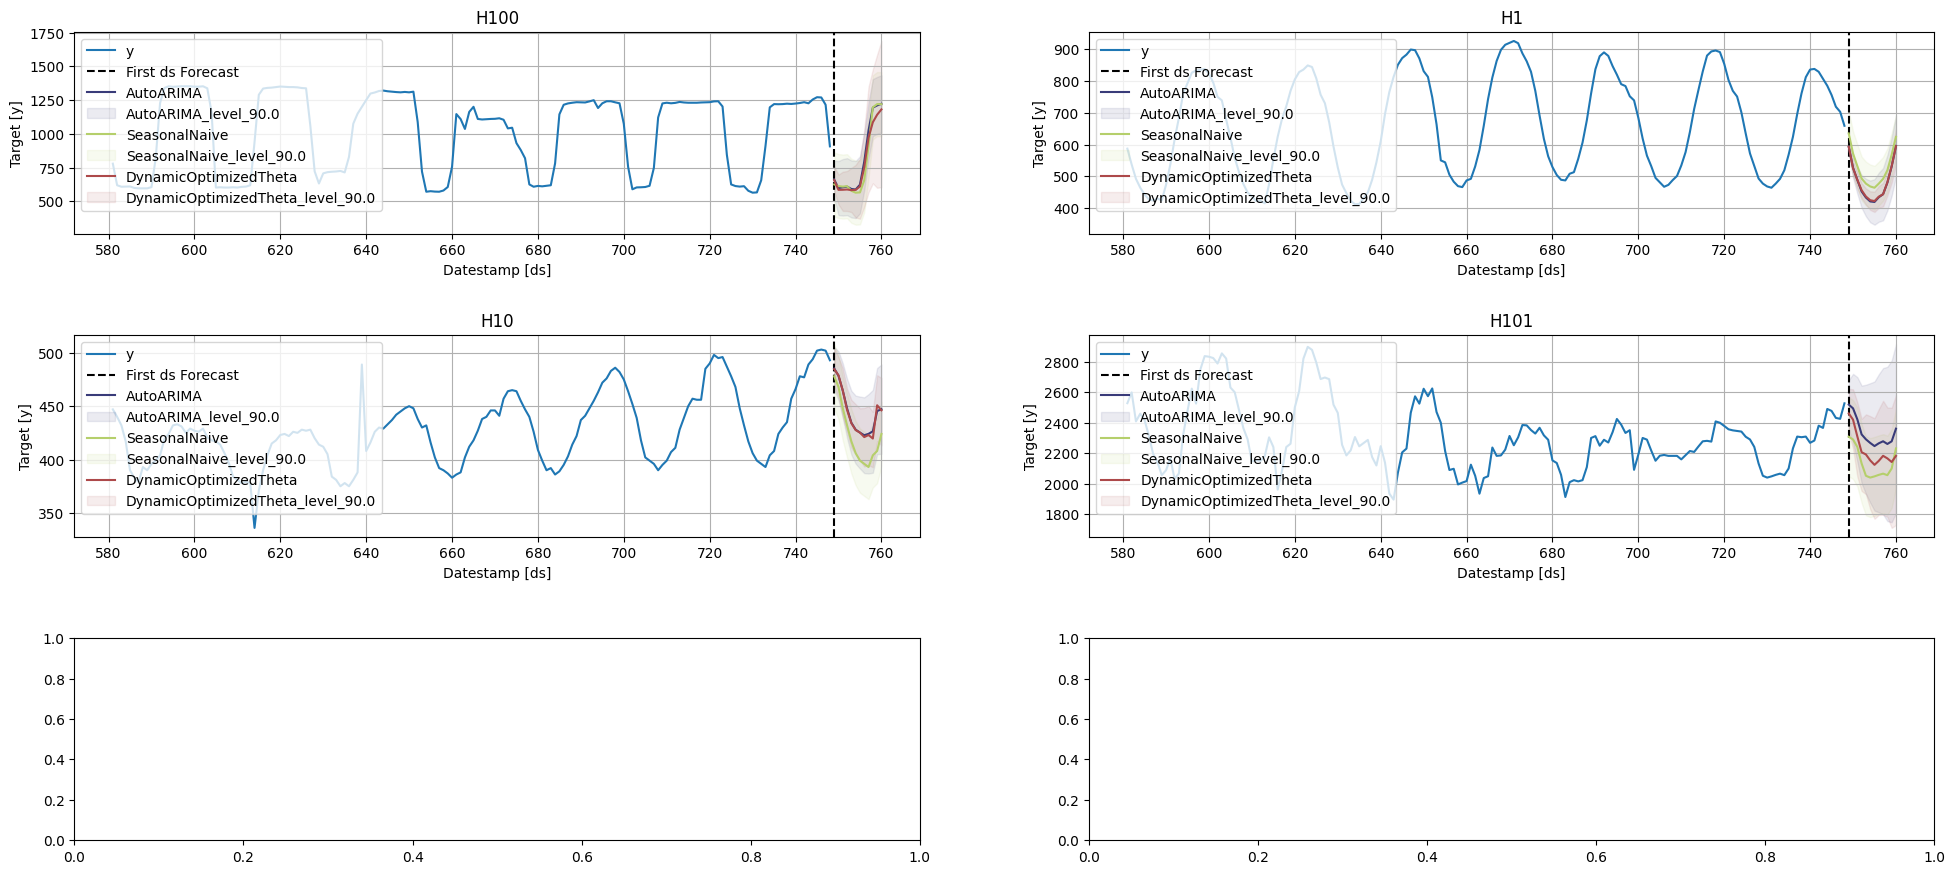

In [7]:
results["inference_plot"]